## Import Libraries 

In [65]:
# Import Libraries
import numpy as np
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

#Import SciKit Learn and Math
import scipy
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

#estimators
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model

#model metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

## Import Dataset

In [66]:
#Import Data
credit = pd.read_csv('credit.csv', skiprows = 1)

In [67]:
#Import Pay Status Table - definitions of pay status (applies to all '_STATUS' columns)
table = pd.read_csv('Pay Legend Table.csv')
table.head(6)

,PAY STATUS,STATUS DEFINITION
0,-2,No consumption
1,-1,Paid in full
2,0,Revolving Credit
3,1,Pay delay 1 month
4,2,Pay delay 2 months
5,9,Pay delay 9+ months


In [68]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  int64 
 1   LIMIT_BAL                   30000 non-null  int64 
 2   SEX                         30000 non-null  object
 3   EDUCATION                   30000 non-null  object
 4   MARRIAGE                    30000 non-null  int64 
 5   AGE                         30000 non-null  int64 
 6   SEPT_STATUS                 30000 non-null  int64 
 7   AUG_STATUS                  30000 non-null  int64 
 8   JULY_STATUS                 30000 non-null  int64 
 9   JUNE_STATUS                 30000 non-null  int64 
 10  MAY_STATUS                  30000 non-null  int64 
 11  APRIL_STATUS                30000 non-null  int64 
 12  SEPT_BILL                   30000 non-null  int64 
 13  AUG_BILL                    30000 non-null  in

In [69]:
#Rename Column 'default payment next month'
credit['default'] = credit ['default payment next month']
#drop unneeded columns
credit=credit.drop(['ID', 'default payment next month'], axis=1)
#drop duplicates
credit = credit.drop_duplicates()
#check for missing values
print(credit.isnull().sum())

LIMIT_BAL        0
SEX              0
EDUCATION        0
MARRIAGE         0
AGE              0
SEPT_STATUS      0
AUG_STATUS       0
JULY_STATUS      0
JUNE_STATUS      0
MAY_STATUS       0
APRIL_STATUS     0
SEPT_BILL        0
AUG_BILL         0
JULY_BILL        0
JUNE_BILL        0
MAY_BILL         0
APRIL_BILL       0
SEPT_PAYMENT     0
AUG_PAYMENT      0
JULY_PAYMENT     0
JUNE_PAYMENT     0
MAY_PAYMENT      0
APRIL_PAYMENT    0
default          0
dtype: int64


In [70]:
#Confirm that 'SEX' has only 2 unique entries and can be Label Encoded
credit['SEX'].describe()

count      29965
unique         2
top       female
freq       18091
Name: SEX, dtype: object

In [71]:
#Confirm that 'default' has only 2 unique entries and can be Label Encoded
credit['default'].describe()

count           29965
unique              2
top       not default
freq            23335
Name: default, dtype: object

In [72]:
#Confirm that "Education" has 4 unique entries and requires One Hot Encoding
credit['EDUCATION'].describe()

count          29965
unique             4
top       university
freq           14019
Name: EDUCATION, dtype: object

In [73]:
#Label Encode 'SEX' to binary 0 and 1 for female and male
le = LabelEncoder()
le.fit(credit['SEX'])
credit['SEX'] = le.transform(credit['SEX'])

In [74]:
#Label Encode 'default' to binary 0 and 1 for 'default' and 'not default', respectively
le = LabelEncoder()
le.fit(credit['default'])
credit['default'] = le.transform(credit['default'])

In [75]:
#Convert pay status=-2 to Zero so that customers paying ontime are not penalized
credit['SEPT_STATUS'] = credit['SEPT_STATUS'].replace(-2,0)
credit['AUG_STATUS'] = credit['AUG_STATUS'].replace(-2,0)
credit['JULY_STATUS'] = credit['JULY_STATUS'].replace(-2,0)
credit['JUNE_STATUS'] = credit['JUNE_STATUS'].replace(-2,0)
credit['MAY_STATUS'] = credit['MAY_STATUS'].replace(-2,0)
credit['APRIL_STATUS'] = credit['APRIL_STATUS'].replace(-2,0)

#Convert pay status=-1 to Zero so that customers paying ontime are not penalized
credit['SEPT_STATUS'] = credit['SEPT_STATUS'].replace(-1,0)
credit['AUG_STATUS'] = credit['AUG_STATUS'].replace(-1,0)
credit['JULY_STATUS'] = credit['JULY_STATUS'].replace(-1,0)
credit['JUNE_STATUS'] = credit['JUNE_STATUS'].replace(-1,0)
credit['MAY_STATUS'] = credit['MAY_STATUS'].replace(-1,0)
credit['APRIL_STATUS'] = credit['APRIL_STATUS'].replace(-1,0)

In [76]:
#Top Rows of Data Set
credit.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,SEPT_STATUS,AUG_STATUS,JULY_STATUS,JUNE_STATUS,MAY_STATUS,...,JUNE_BILL,MAY_BILL,APRIL_BILL,SEPT_PAYMENT,AUG_PAYMENT,JULY_PAYMENT,JUNE_PAYMENT,MAY_PAYMENT,APRIL_PAYMENT,default
0,20000,0,university,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,0
1,120000,0,university,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,0
2,90000,0,university,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,1
3,50000,0,university,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,1
4,50000,1,university,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,1


In [77]:
#Create Age Bins by Generation, Gen Z=18-25, Millenial=26-40, GenX=41-55, Baby Boomers=56-80
bins = [0,25,40,55,80]
#group names
gen = ['Gen Z','Millennial','Gen X','Boomer']

In [78]:
credit['Generation'] = pd.cut(credit.AGE, bins, labels = gen)

In [79]:
#CREDIT LIMIT BIN - lOW
binslimit = [0,50000, 100000,200000,300000,500000,1000000]
#group names
limits = ['LOW','LOWMED','MED','MEDHIGH','HIGH','MAX']

In [80]:
credit['LIMIT_BIN'] = pd.cut(credit.LIMIT_BAL, binslimit, labels = limits)

In [81]:
credit.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,SEPT_STATUS,AUG_STATUS,JULY_STATUS,JUNE_STATUS,MAY_STATUS,...,APRIL_BILL,SEPT_PAYMENT,AUG_PAYMENT,JULY_PAYMENT,JUNE_PAYMENT,MAY_PAYMENT,APRIL_PAYMENT,default,Generation,LIMIT_BIN
0,20000,0,university,1,24,2,2,0,0,0,...,0,0,689,0,0,0,0,0,Gen Z,LOW
1,120000,0,university,2,26,0,2,0,0,0,...,3261,0,1000,1000,1000,0,2000,0,Millennial,MED
2,90000,0,university,2,34,0,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,1,Millennial,LOWMED
3,50000,0,university,1,37,0,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,1,Millennial,LOW
4,50000,1,university,1,57,0,0,0,0,0,...,19131,2000,36681,10000,9000,689,679,1,Boomer,LOW


In [82]:
#Basic Statistical Information of the Dataset
credit.describe()

,LIMIT_BAL,SEX,MARRIAGE,AGE,SEPT_STATUS,AUG_STATUS,JULY_STATUS,JUNE_STATUS,MAY_STATUS,APRIL_STATUS,...,JUNE_BILL,MAY_BILL,APRIL_BILL,SEPT_PAYMENT,AUG_PAYMENT,JULY_PAYMENT,JUNE_PAYMENT,MAY_PAYMENT,APRIL_PAYMENT,default
count,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,...,29965.000000,29965.000000,29965.000000,29965.000000,2.996500e+04,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000
mean,167442.005006,0.396262,1.551877,35.487969,0.356416,0.320340,0.304288,0.258935,0.221625,0.226698,...,43313.329885,40358.334390,38917.012281,5670.099316,5.927983e+03,5231.688837,4831.617454,4804.897047,5221.498014,0.778742
std,129760.135222,0.489128,0.521997,9.219459,0.760752,0.802064,0.790696,0.761200,0.717768,0.715483,...,64353.514373,60817.130623,59574.147742,16571.849467,2.305346e+04,17616.361124,15674.464538,15286.372298,17786.976864,0.415101
min,10000.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,0.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2360.000000,1787.000000,1262.000000,1000.000000,8.500000e+02,390.000000,300.000000,261.000000,131.000000,1.000000
50%,140000.000000,0.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19081.000000,18130.000000,17124.000000,2102.000000,2.010000e+03,1804.000000,1500.000000,1500.000000,1500.000000,1.000000
75%,240000.000000,1.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54601.000000,50247.000000,49252.000000,5008.000000,5.000000e+03,4512.000000,4016.000000,4042.000000,4000.000000,1.000000
max,1000000.000000,1.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


In [83]:
#Check Data Types of each variable
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29965 entries, 0 to 29999
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   LIMIT_BAL      29965 non-null  int64   
 1   SEX            29965 non-null  int32   
 2   EDUCATION      29965 non-null  object  
 3   MARRIAGE       29965 non-null  int64   
 4   AGE            29965 non-null  int64   
 5   SEPT_STATUS    29965 non-null  int64   
 6   AUG_STATUS     29965 non-null  int64   
 7   JULY_STATUS    29965 non-null  int64   
 8   JUNE_STATUS    29965 non-null  int64   
 9   MAY_STATUS     29965 non-null  int64   
 10  APRIL_STATUS   29965 non-null  int64   
 11  SEPT_BILL      29965 non-null  int64   
 12  AUG_BILL       29965 non-null  int64   
 13  JULY_BILL      29965 non-null  int64   
 14  JUNE_BILL      29965 non-null  int64   
 15  MAY_BILL       29965 non-null  int64   
 16  APRIL_BILL     29965 non-null  int64   
 17  SEPT_PAYMENT   29965 non-null  

In [84]:
#check for missing values
print(credit.isnull().sum())

LIMIT_BAL        0
SEX              0
EDUCATION        0
MARRIAGE         0
AGE              0
SEPT_STATUS      0
AUG_STATUS       0
JULY_STATUS      0
JUNE_STATUS      0
MAY_STATUS       0
APRIL_STATUS     0
SEPT_BILL        0
AUG_BILL         0
JULY_BILL        0
JUNE_BILL        0
MAY_BILL         0
APRIL_BILL       0
SEPT_PAYMENT     0
AUG_PAYMENT      0
JULY_PAYMENT     0
JUNE_PAYMENT     0
MAY_PAYMENT      0
APRIL_PAYMENT    0
default          0
Generation       0
LIMIT_BIN        0
dtype: int64


In [85]:
#check for data types (numeric/nominal)
credit.dtypes

LIMIT_BAL           int64
SEX                 int32
EDUCATION          object
MARRIAGE            int64
AGE                 int64
SEPT_STATUS         int64
AUG_STATUS          int64
JULY_STATUS         int64
JUNE_STATUS         int64
MAY_STATUS          int64
APRIL_STATUS        int64
SEPT_BILL           int64
AUG_BILL            int64
JULY_BILL           int64
JUNE_BILL           int64
MAY_BILL            int64
APRIL_BILL          int64
SEPT_PAYMENT        int64
AUG_PAYMENT         int64
JULY_PAYMENT        int64
JUNE_PAYMENT        int64
MAY_PAYMENT         int64
APRIL_PAYMENT       int64
default             int32
Generation       category
LIMIT_BIN        category
dtype: object

## EDA Exploratory Data Analysis

In [86]:
#print column heading names in dataframe for use to generate plots
header = credit.dtypes.index
print(header)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'SEPT_STATUS',
       'AUG_STATUS', 'JULY_STATUS', 'JUNE_STATUS', 'MAY_STATUS',
       'APRIL_STATUS', 'SEPT_BILL', 'AUG_BILL', 'JULY_BILL', 'JUNE_BILL',
       'MAY_BILL', 'APRIL_BILL', 'SEPT_PAYMENT', 'AUG_PAYMENT', 'JULY_PAYMENT',
       'JUNE_PAYMENT', 'MAY_PAYMENT', 'APRIL_PAYMENT', 'default', 'Generation',
       'LIMIT_BIN'],
      dtype='object')


## Histograms

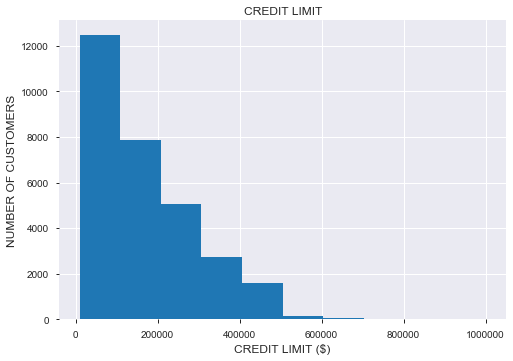

In [87]:
#histogram of customer credit limit with 10 bins
plt.hist(credit['LIMIT_BAL'], bins=10)
plt.xlabel('CREDIT LIMIT ($)', fontsize='large')
plt.ylabel('NUMBER OF CUSTOMERS', fontsize='large')
plt.title('CREDIT LIMIT', fontsize='large')
plt.show()

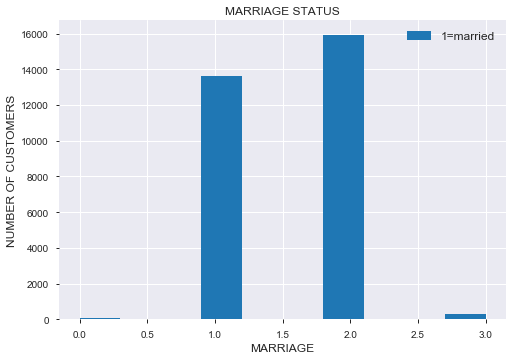

In [88]:
#histogram of marriage NEED TO FIX THE LEGEND 0=other, 1=married, 2=single, 3=divorced
plt.hist(credit['MARRIAGE'])
plt.xlabel('MARRIAGE', fontsize='large')
plt.ylabel('NUMBER OF CUSTOMERS', fontsize='large')
plt.title('MARRIAGE STATUS', fontsize='large')
plt.legend(('1=married', '2=single', '3=divorced', '0=other'), loc='best', fontsize='large')
plt.show()

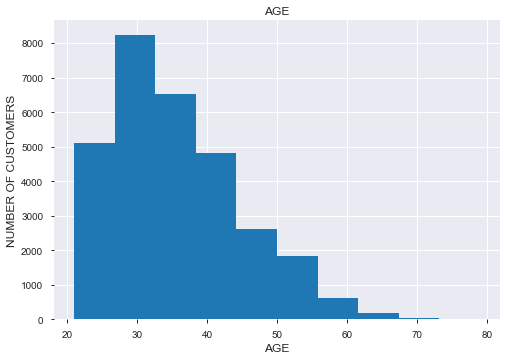

In [89]:
#histogram of age with 10 bins
plt.hist(credit['AGE'],bins = 10)
plt.xlabel('AGE', fontsize='large')
plt.ylabel('NUMBER OF CUSTOMERS', fontsize='large')
plt.title('AGE', fontsize='large')
plt.show()

Text(0.5, 1.0, 'Distribution of Customer Ages')

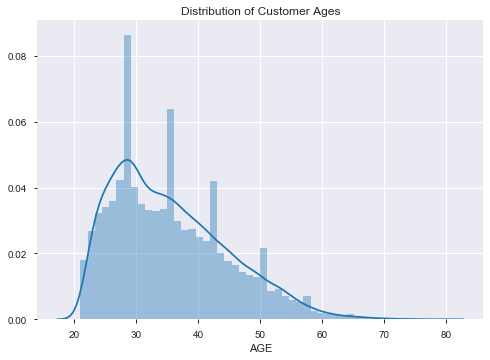

In [90]:
#Distribution plot of customer ages, with an overlay of a density plot
age = credit['AGE']
age_dist=sns.distplot(age)
age_dist.set_title("Distribution of Customer Ages")

## Line Plots

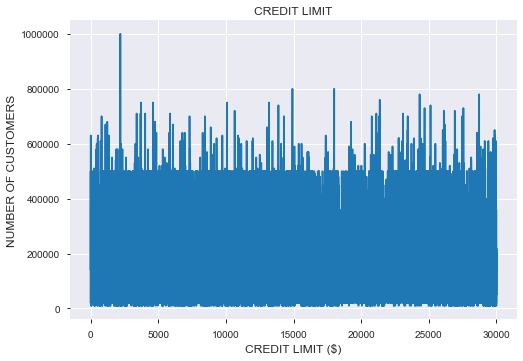

In [91]:
#line plot of credit limit
plt.plot(credit['LIMIT_BAL'])
plt.xlabel('CREDIT LIMIT ($)', fontsize='large')
plt.ylabel('NUMBER OF CUSTOMERS', fontsize='large')
plt.title('CREDIT LIMIT', fontsize='large')
plt.show()

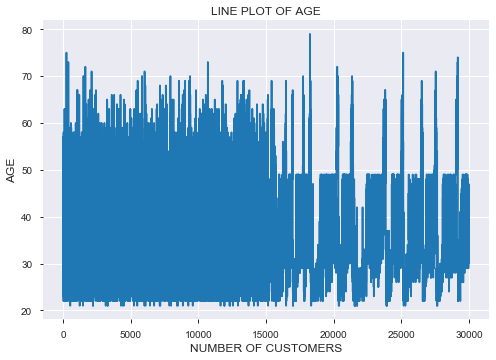

In [92]:
#line plot of age
plt.plot(credit['AGE'])
plt.xlabel('NUMBER OF CUSTOMERS', fontsize='large')
plt.ylabel('AGE', fontsize='large')
plt.title('LINE PLOT OF AGE', fontsize='large')
plt.show()

## Scatter Plots

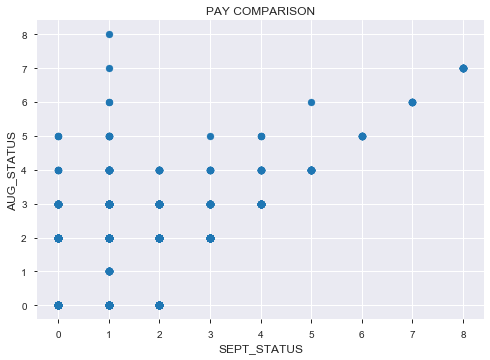

In [93]:
# Scatter plot comparing Sept status vs Aug status
x = credit['SEPT_STATUS']
y = credit['AUG_STATUS']
plt.scatter(x,y)
plt.xlabel('SEPT_STATUS', fontsize='large')
plt.ylabel('AUG_STATUS', fontsize='large')
plt.title('PAY COMPARISON', fontsize='large')
plt.show()

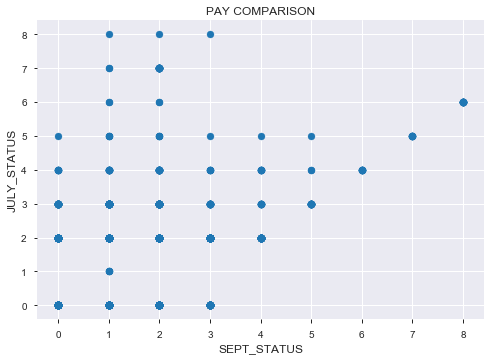

In [94]:
# Scatter plot comparing Sept status vs July status
x = credit['SEPT_STATUS']
y = credit['JULY_STATUS']
plt.scatter(x,y)
plt.xlabel('SEPT_STATUS', fontsize='large')
plt.ylabel('JULY_STATUS', fontsize='large')
plt.title('PAY COMPARISON', fontsize='large')
plt.show()

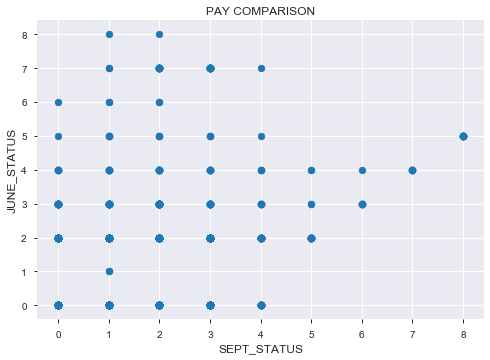

In [95]:
# Scatter plot comparing Sept status vs June status
x = credit['SEPT_STATUS']
y = credit['JUNE_STATUS']
plt.scatter(x,y)
plt.xlabel('SEPT_STATUS', fontsize='large')
plt.ylabel('JUNE_STATUS', fontsize='large')
plt.title('PAY COMPARISON', fontsize='large')
plt.show()

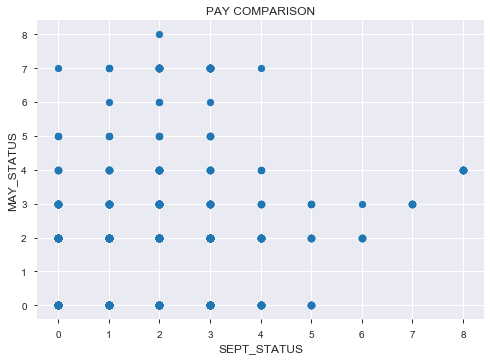

In [96]:
# Scatter plot comparing Sept status vs May status
x = credit['SEPT_STATUS']
y = credit['MAY_STATUS']
plt.scatter(x,y)
plt.xlabel('SEPT_STATUS', fontsize='large')
plt.ylabel('MAY_STATUS', fontsize='large')
plt.title('PAY COMPARISON', fontsize='large')
plt.show()

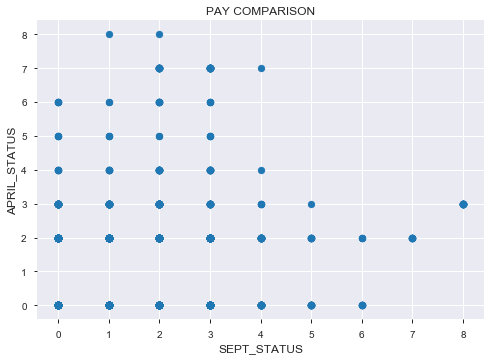

In [97]:
# Scatter plot comparing Sept status vs April status
x = credit['SEPT_STATUS']
y = credit['APRIL_STATUS']
plt.scatter(x,y)
plt.xlabel('SEPT_STATUS', fontsize='large')
plt.ylabel('APRIL_STATUS', fontsize='large')
plt.title('PAY COMPARISON', fontsize='large')
plt.show()

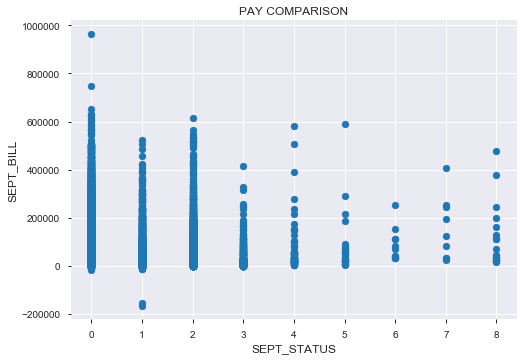

In [98]:
# Scatter plot comparing Sept Status vs September Bill
x = credit['SEPT_STATUS']
y = credit['SEPT_BILL']
plt.scatter(x,y)
plt.xlabel('SEPT_STATUS', fontsize='large')
plt.ylabel('SEPT_BILL', fontsize='large')
plt.title('PAY COMPARISON', fontsize='large')
plt.show()

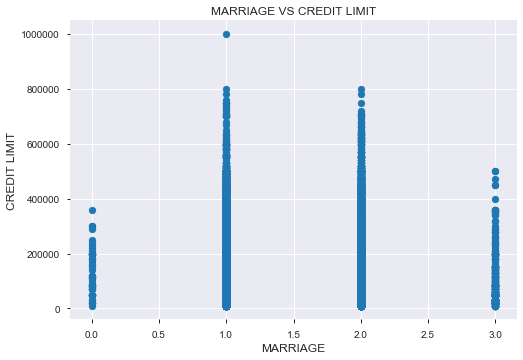

In [99]:
# Scatter plot of Marriage vs Credit Limit (0=OTHER, 1=MARRIED, 2=SINGLE, 3=DIVORCED)
x = credit['MARRIAGE']
y = credit['LIMIT_BAL']
plt.scatter(x,y)
plt.xlabel('MARRIAGE', fontsize='large')
plt.ylabel('CREDIT LIMIT', fontsize='large')
plt.title('MARRIAGE VS CREDIT LIMIT', fontsize='large')
plt.show()

## Seaborn Plots

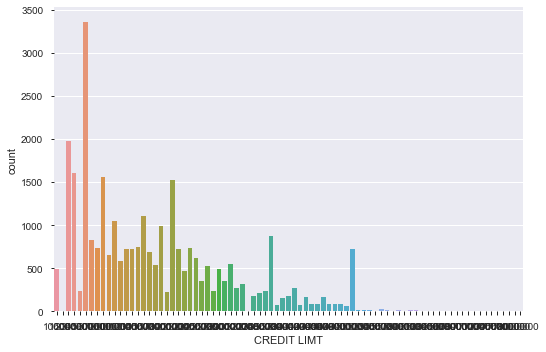

In [100]:
#Plot of CREDIT LIMIT
fg = sns.catplot('LIMIT_BAL', data=credit, kind='count', aspect=1.5)
fg.set_xlabels('CREDIT LIMT')

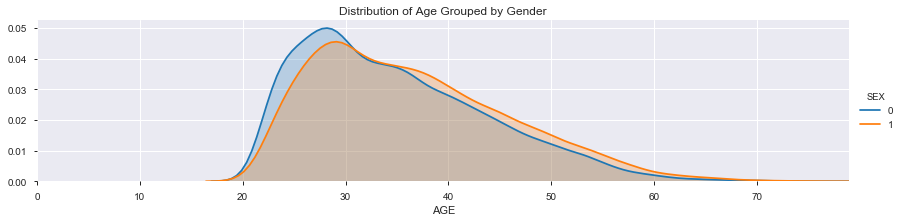

In [101]:
# distribution of age grouped by gender
fig = sns.FacetGrid(credit, hue='SEX', aspect=4)
fig.map(sns.kdeplot, 'AGE', shade=True)
oldest = credit['AGE'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Age Grouped by Gender')
fig.add_legend()

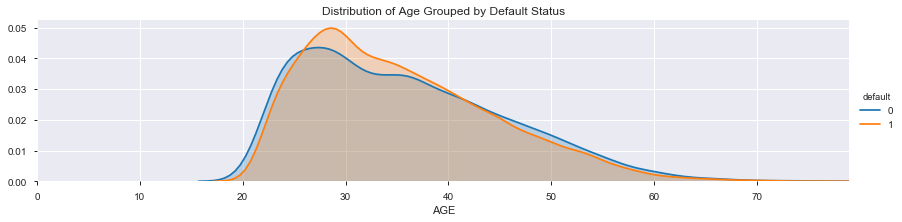

In [103]:
#Distribution of Age grouped by Default Status
fig = sns.FacetGrid(credit, hue='default', aspect=4)
fig.map(sns.kdeplot, 'AGE', shade=True)
oldest = credit['AGE'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Age Grouped by Default Status')
fig.add_legend()

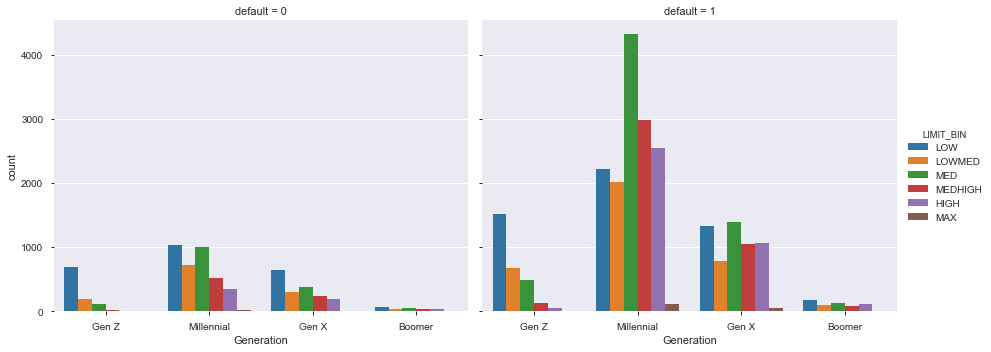

In [109]:
# Catplot of customers split by default-not default, Generation, and Credit Limit (Credit Limit bins below)
#LOW = 0-50K, LOWMED = 50K-100K, MED = 100K-200K, MEDHIGH = 200-300K, HIGH = 300K-500K, MAX = 500K-1MM
sns.catplot('Generation', data=credit, kind='count', hue='LIMIT_BIN', col='default', order=['Gen Z','Millennial','Gen X','Boomer'], 
               hue_order=['LOW','LOWMED','MED','MEDHIGH','HIGH','MAX'], aspect=1.25, height=5)

In [110]:
#Column Headers
header =  credit.dtypes.index
print(header)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'SEPT_STATUS',
       'AUG_STATUS', 'JULY_STATUS', 'JUNE_STATUS', 'MAY_STATUS',
       'APRIL_STATUS', 'SEPT_BILL', 'AUG_BILL', 'JULY_BILL', 'JUNE_BILL',
       'MAY_BILL', 'APRIL_BILL', 'SEPT_PAYMENT', 'AUG_PAYMENT', 'JULY_PAYMENT',
       'JUNE_PAYMENT', 'MAY_PAYMENT', 'APRIL_PAYMENT', 'default', 'Generation',
       'LIMIT_BIN'],
      dtype='object')


## Box Plots Bills

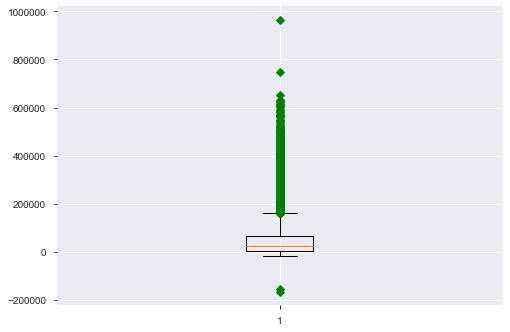

In [111]:
#box plot of Sept Bill
A = credit['SEPT_BILL']
plt.boxplot(A,0,'gD')
plt.show()

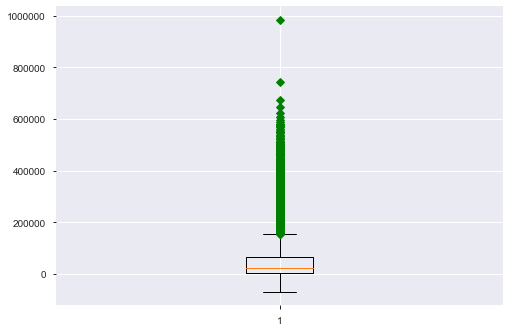

In [112]:
#box plot of Aug Bill
A = credit['AUG_BILL']
plt.boxplot(A,0,'gD')
plt.show()

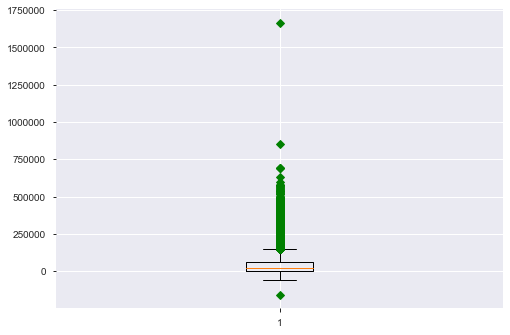

In [113]:
#box plot of July Bill
A = credit['JULY_BILL']
plt.boxplot(A,0,'gD')
plt.show()

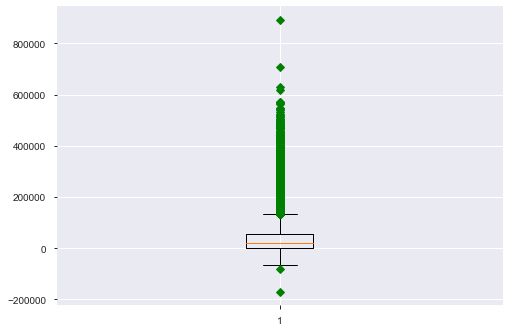

In [114]:
#box plot of June Bill
A = credit['JUNE_BILL']
plt.boxplot(A,0,'gD')
plt.show()

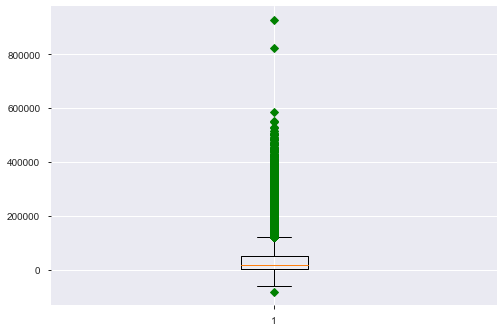

In [115]:
#box plot of May Bill
A = credit['MAY_BILL']
plt.boxplot(A,0,'gD')
plt.show()

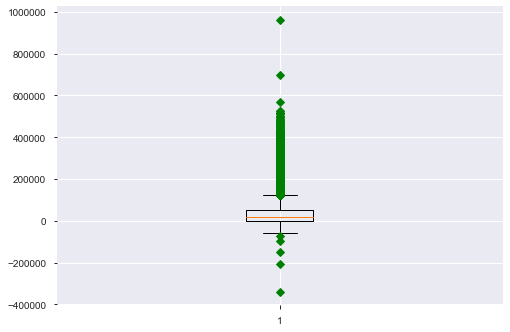

In [116]:
#box plot of April Bill
A = credit['APRIL_BILL']
plt.boxplot(A,0,'gD')
plt.show()

## Box Plots Payments

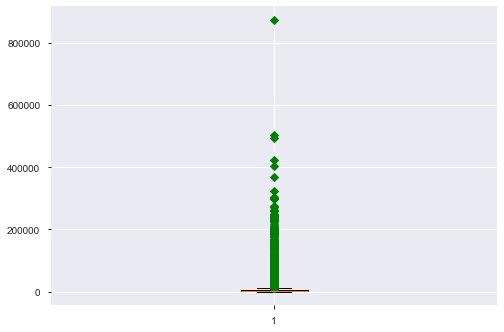

In [117]:
#box plot of Sept Payment
A = credit['SEPT_PAYMENT']
plt.boxplot(A,0,'gD')
plt.show()

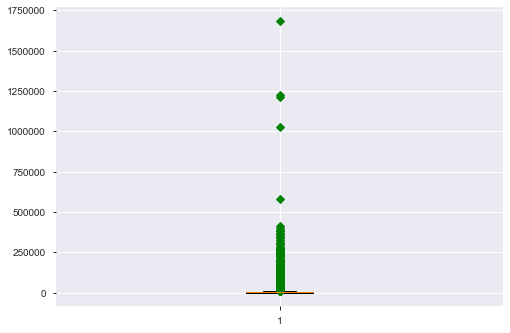

In [118]:
#box plot of Aug Payment
A = credit['AUG_PAYMENT']
plt.boxplot(A,0,'gD')
plt.show()

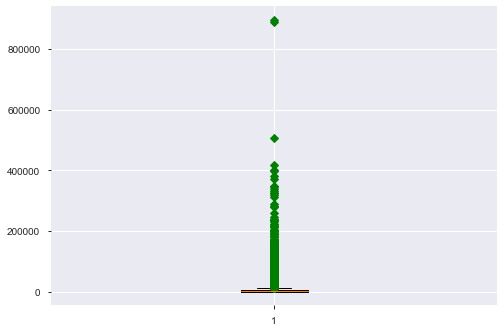

In [119]:
#box plot of July Payment
A = credit['JULY_PAYMENT']
plt.boxplot(A,0,'gD')
plt.show()

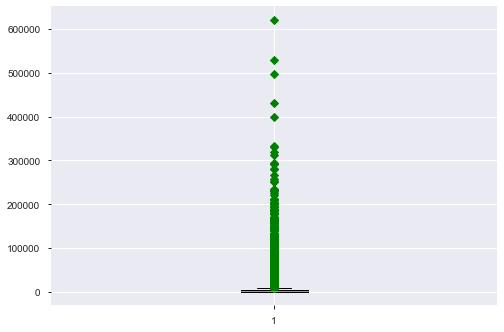

In [120]:
#box plot of June Payment
A = credit['JUNE_PAYMENT']
plt.boxplot(A,0,'gD')
plt.show()

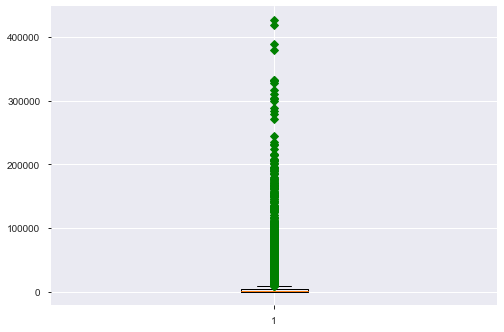

In [121]:
#box plot of May Payment
A = credit['MAY_PAYMENT']
plt.boxplot(A,0,'gD')
plt.show()

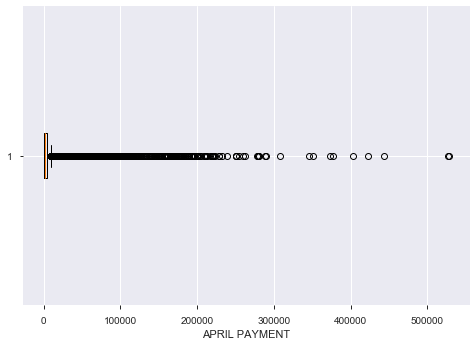

In [122]:
#box plot of April Payment displaying a horizontal portrayal option
plt.boxplot(credit.APRIL_PAYMENT, vert=False)
plt.xlabel('APRIL PAYMENT')
plt.show()

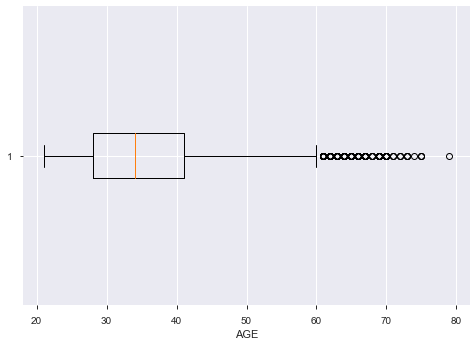

In [123]:
#Box Plot of Age
plt.boxplot(credit.AGE, vert=False)
plt.xlabel('AGE')
plt.show()

In [133]:
#Converts non-numeric column (Education) to 'dummy variables' so they can be used for regression.  Binary 0 or 1
credit = pd.get_dummies(credit)

In [134]:
#Confirm new dummy variable columns for Education, Sex, Default
credit.head()

,LIMIT_BAL,SEX,MARRIAGE,AGE,SEPT_STATUS,AUG_STATUS,JULY_STATUS,JUNE_STATUS,MAY_STATUS,APRIL_STATUS,...,Generation_Gen Z,Generation_Millennial,Generation_Gen X,Generation_Boomer,LIMIT_BIN_LOW,LIMIT_BIN_LOWMED,LIMIT_BIN_MED,LIMIT_BIN_MEDHIGH,LIMIT_BIN_HIGH,LIMIT_BIN_MAX
0,20000,0,1,24,2,2,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,120000,0,2,26,0,2,0,0,0,2,...,0,1,0,0,0,0,1,0,0,0
2,90000,0,2,34,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,50000,0,1,37,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,50000,1,1,57,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [135]:
#Ensure all data types are now numeric
credit.dtypes

LIMIT_BAL                    int64
SEX                          int32
MARRIAGE                     int64
AGE                          int64
SEPT_STATUS                  int64
AUG_STATUS                   int64
JULY_STATUS                  int64
JUNE_STATUS                  int64
MAY_STATUS                   int64
APRIL_STATUS                 int64
SEPT_BILL                    int64
AUG_BILL                     int64
JULY_BILL                    int64
JUNE_BILL                    int64
MAY_BILL                     int64
APRIL_BILL                   int64
SEPT_PAYMENT                 int64
AUG_PAYMENT                  int64
JULY_PAYMENT                 int64
JUNE_PAYMENT                 int64
MAY_PAYMENT                  int64
APRIL_PAYMENT                int64
default                      int32
EDUCATION_graduate school    uint8
EDUCATION_high school        uint8
EDUCATION_other              uint8
EDUCATION_university         uint8
Generation_Gen Z             uint8
Generation_Millennia

## Correlation/Covariance

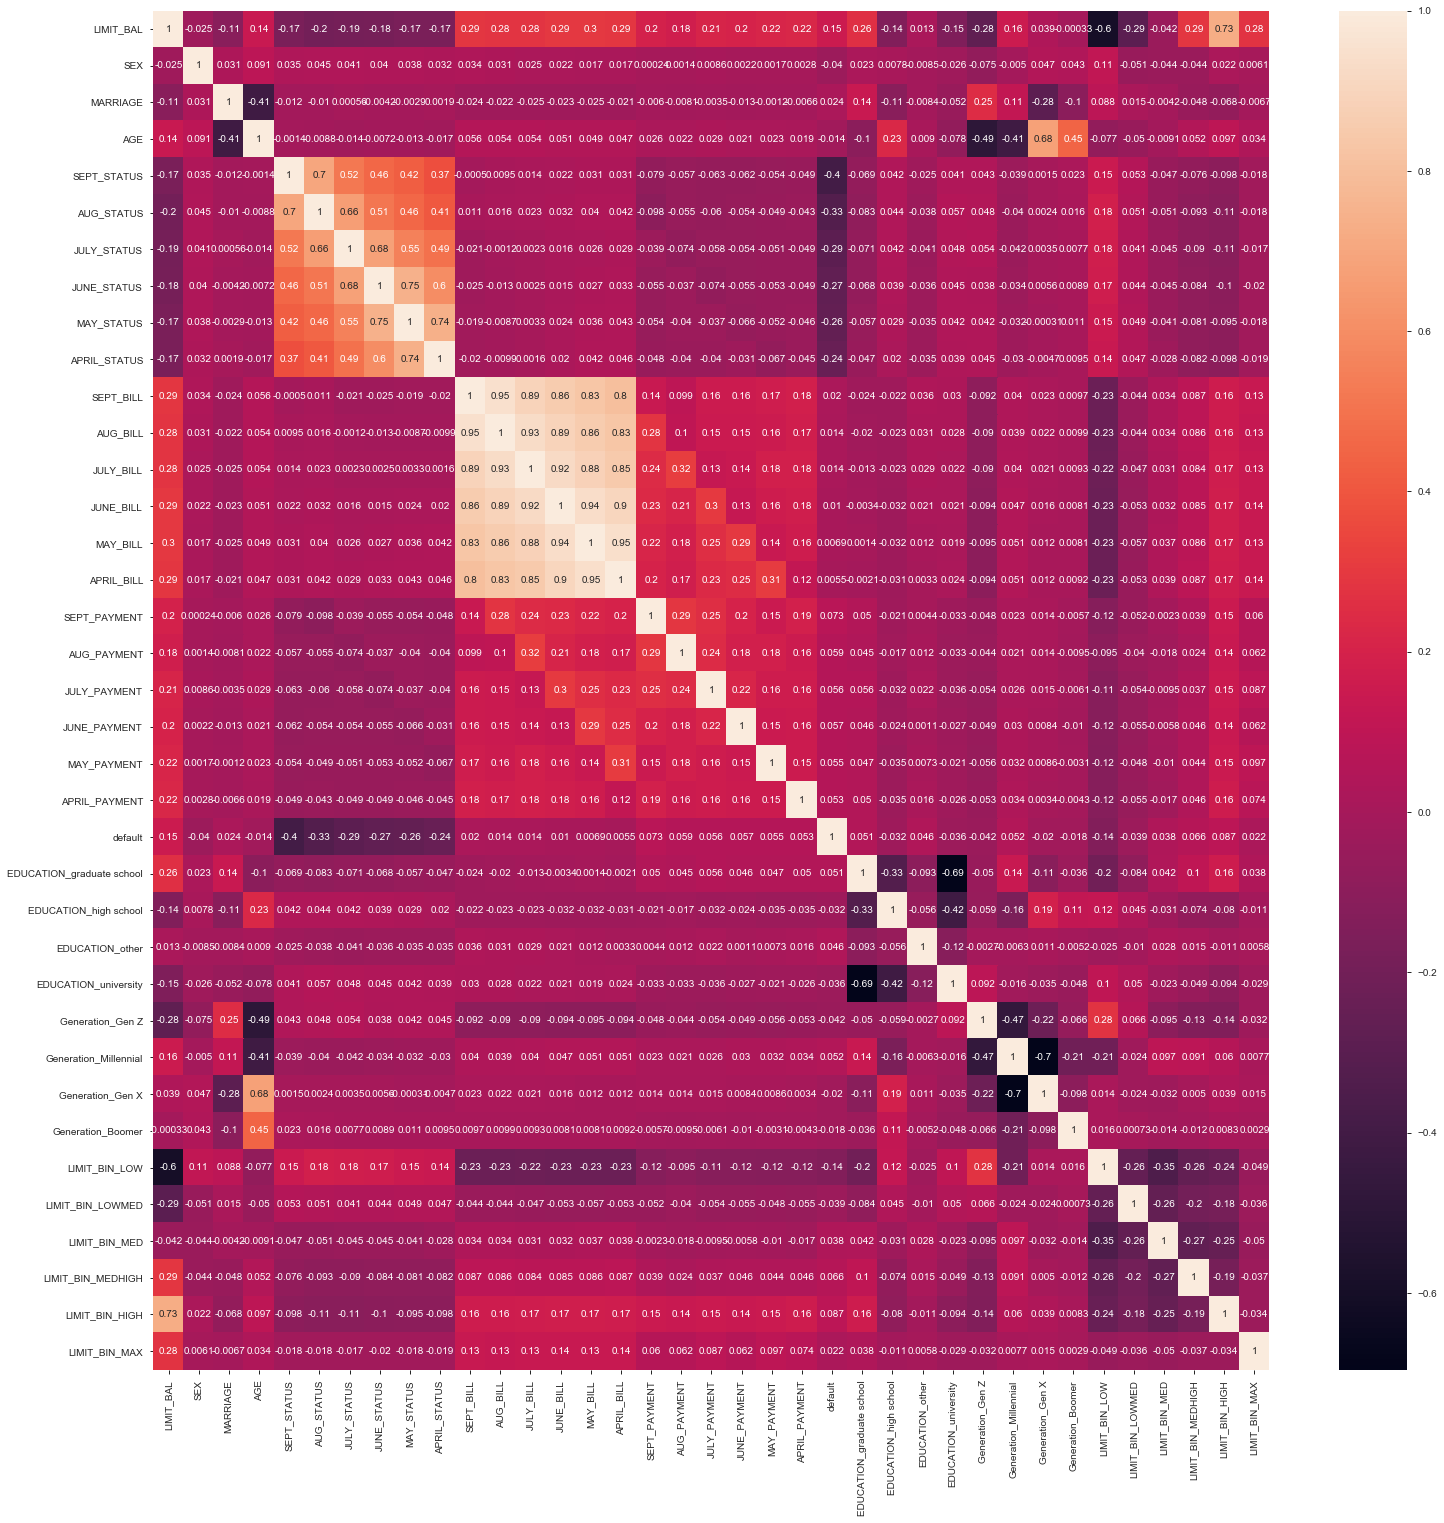

In [138]:
#correlation
credit_corr = credit.corr()
plt.figure(figsize=(25,25))
sns.heatmap(credit_corr, annot=True)
plt.show()

## Correlation Findings

In [ ]:
#Findings: Pay Status, Sex, Marriage, and Education (university, high school, other) have low correlation and can be removed

In [141]:
#Drop additional unneeded columns
credit = credit.drop(['SEPT_STATUS', 'AUG_STATUS', 'JULY_STATUS', 'JUNE_STATUS', 'MAY_STATUS', 'APRIL_STATUS', 'MARRIAGE', 'SEX', 'EDUCATION_high school', 'EDUCATION_other', 'EDUCATION_university'], axis=1)

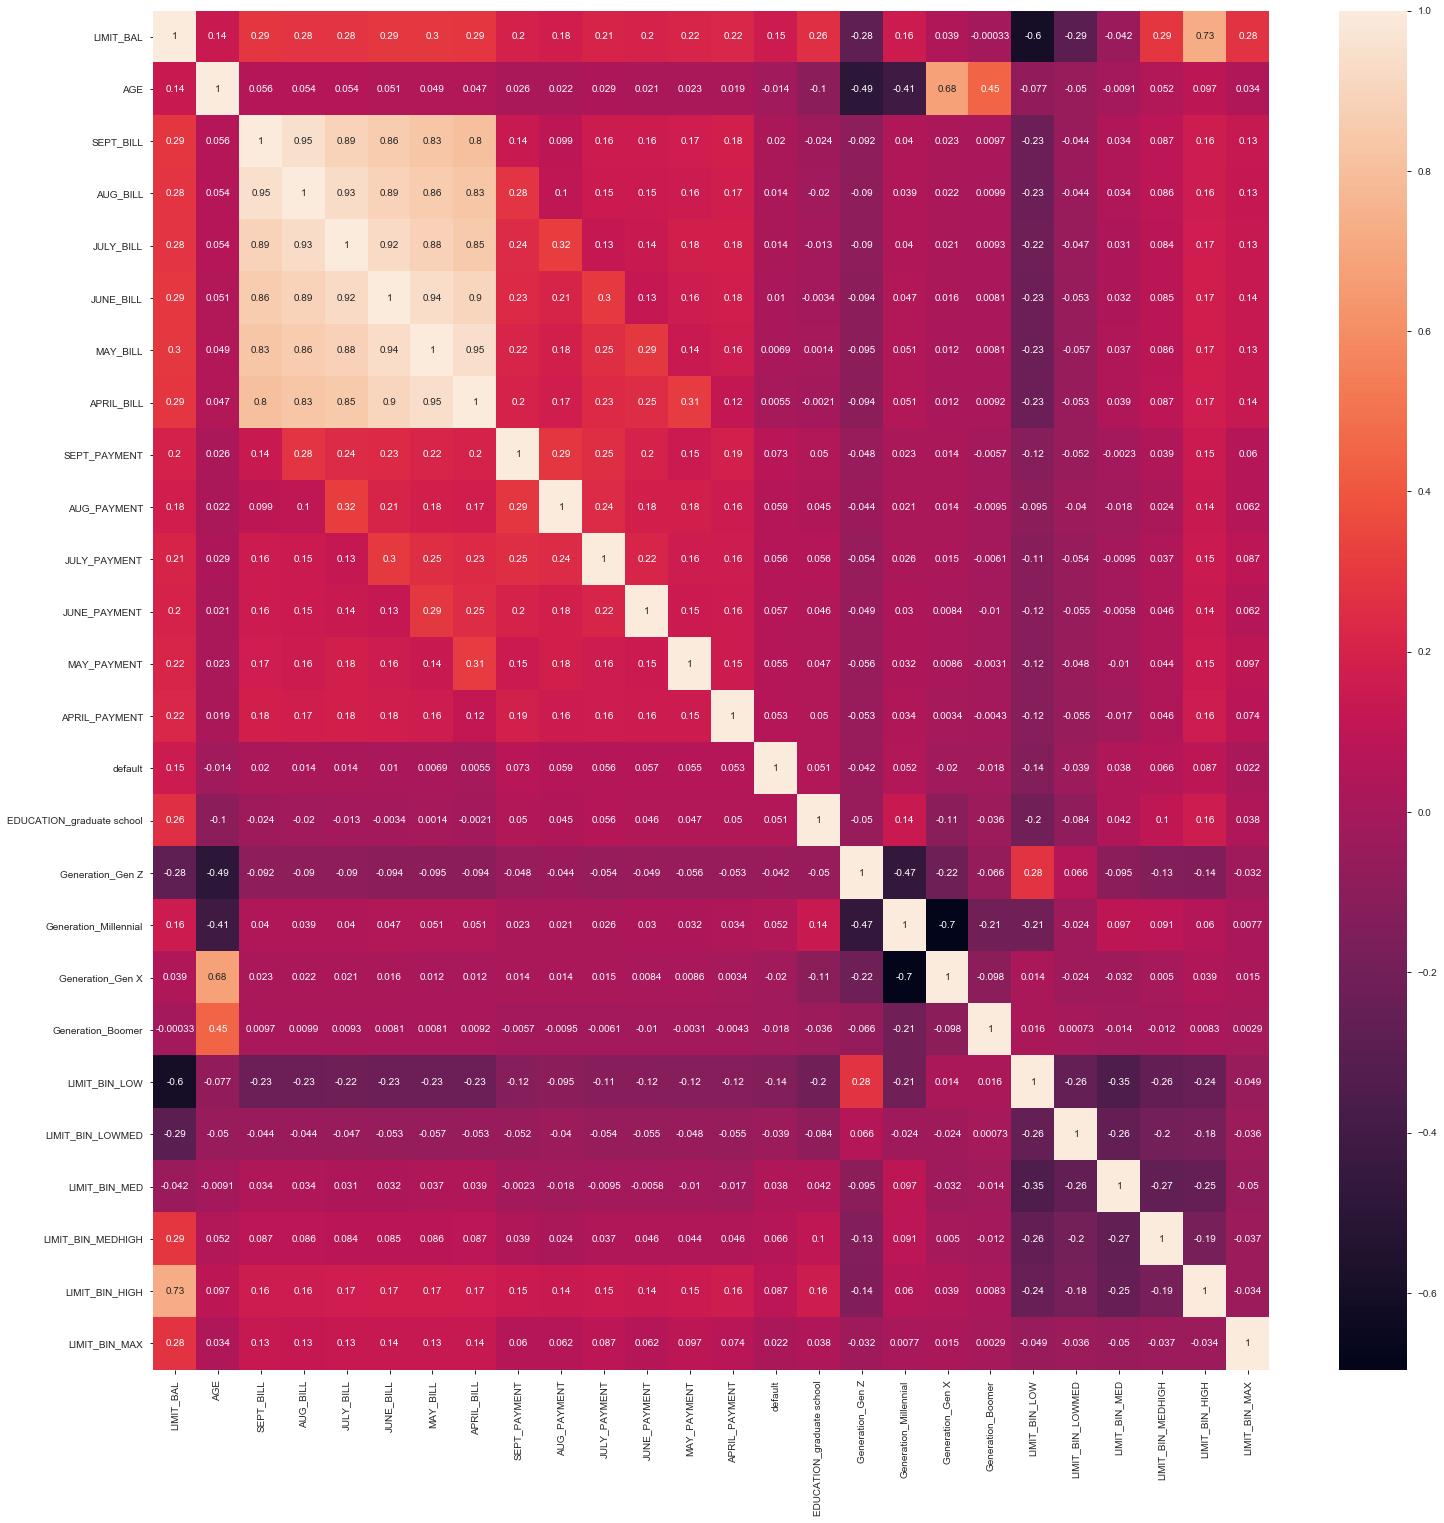

In [142]:
#repeat correlation matrix
credit_corr = credit.corr()
plt.figure(figsize=(25,25))
sns.heatmap(credit_corr, annot=True)
plt.show()